In [1]:
import pandas as pd
import numpy as np
import glob as glob
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Embedding, Dot
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
# from data_parser import DataParser
# from skip_gram import SkipGramModel

In [2]:
courses = pd.read_csv('/Users/rsciagli/documents/Fall2020/BAR/STU_CRS_TBL_full.csv', encoding='latin', dtype={'CRS_ID':str})
#courses.head()

/Users/rsciagli/opt/anaconda3/envs/dataweekends/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# courses['CRS_ID'].isnull().sum()
# courses['CRS_ID'].astype(float).isnull().sum()
# courses[['CRS_ID','EARNED_BFORE_COHORT']]
# for dummy, df in courses.groupby('EARNED_BFORE_COHORT')['CRS_ID']:
#     print(dummy)
#     print(len(df))
#     display(df.isnull().sum())

In [4]:
#courses_sample = courses

In [5]:
courses['crs_ofcl_grd_nbr'.upper()].unique()
mask_type = courses['CRS_TYPE']=='ENRL'
discarded_grades = ['ZZ']
discarded_transfer_crs = ['Y']                          
mask_grade = ~courses['CRS_OFCL_GRD_CD'].isin(discarded_grades)                          
mask = mask_grade&mask_type
crs_embed_subset = courses[mask]

In [6]:
crs_df = pd.DataFrame(crs_embed_subset)
crs_df['agg_id'] = crs_df['CRS_ID'].astype(str)
print(crs_df['agg_id'].isnull().values.any())
print(crs_df['CRS_ID'].astype(str).isnull().values.any())

False
False


In [7]:
subj_by_id = crs_df['agg_id'].value_counts()
big_subj_by_id = subj_by_id[subj_by_id>10].index
crs_df['agg_id'] = np.where(crs_df['agg_id'].isin(big_subj_by_id), crs_df['agg_id'],'not_in_final_results')
#pd.Series(pruned_id).value_counts()

In [8]:
#plt.hist(courses['CRS_SUBJ_DEPT_CD'].value_counts(), log=True, bins=[0,10,20,30,40,50,60,70,80,90,100])
orphan_classes = crs_df[crs_df['agg_id']=='not_in_final_results']
crs_dept_cd = orphan_classes['CRS_SUBJ_DEPT_CD'].value_counts()
big_dept = crs_dept_cd[crs_dept_cd>10].index
crs_df['agg_id'] = np.where(crs_df['agg_id'] != 'not_in_final_results', crs_df['agg_id'],
                                        np.where(crs_df['CRS_SUBJ_DEPT_CD'].isin(big_dept),
                                        crs_df['CRS_SUBJ_DEPT_CD'], 'other_dept'))    
pd.Series(crs_df['agg_id']).value_counts()
pd.Series(crs_df['agg_id']).value_counts()['other_dept']

346

In [9]:
print(crs_df['agg_id'].isnull().values.any())
#pd.Series(pruned_dept).value_counts()

False


(array([  0., 997., 662., 490., 326., 298., 243., 222., 201., 183.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 <a list of 10 Patch objects>)

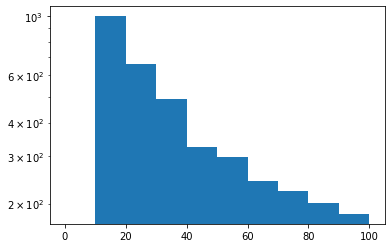

In [10]:
plt.hist(crs_df['agg_id'].value_counts(), log=True, bins=[0,10,20,30,40,50,60,70,80,90,100])
# print(crs_df['agg_id'].nunique())
# print(crs_df['agg_id'].count())
# print(crs_df['agg_id'].value_counts())

In [11]:
def helper(x):
    output = x
    try:
        int(x)
        output = None
    except:
        pass
    return output

[x for x in list(map(helper, crs_df['agg_id'].value_counts().index)) if x]

['MUS',
 'HER',
 'ENG',
 'HIST',
 'other_dept',
 'CSCI',
 'BUS',
 'RADI',
 'SOC',
 'REL',
 'BIOL',
 'CEUS',
 'PSY',
 'THTR',
 'ANTH',
 'FINA',
 'NEWM',
 'MATH',
 'HPER',
 'EDUC',
 'VCD',
 'SPEA',
 'SPAN',
 'PHIL',
 'OVST',
 'RADS',
 'COMM',
 'SLAV',
 'AHLT',
 'PBHL',
 'HIA',
 'GEOG',
 'PPOL',
 'PHYS',
 'POLS',
 'GER',
 'HIM',
 'FREN',
 'MET',
 'INFO',
 'SPCH',
 'ECE',
 'BME',
 'JOUR',
 'CIT',
 'INTR',
 'INST',
 'GEOL',
 'HISP',
 'CLAS',
 'PATH',
 'CGT',
 'NURS',
 'HSC',
 'NELC',
 'EALC',
 'CJUS',
 'SPH',
 'ME',
 'ECON',
 'CEMT',
 'CHEM',
 'LING',
 'AAAD',
 'ECET',
 'CJHS',
 'SHRS',
 'PAHM',
 'OLS',
 'AFRO',
 'KINE',
 'CMLT',
 'PHST',
 'ASL',
 'TEL',
 'ENGR',
 'RADX',
 'EMER',
 'FOLK',
 'JSTU',
 'MA',
 'WGS',
 'COM',
 'MSCH',
 'HON',
 'LTAM',
 'SOAD',
 'NMAT',
 'DHYG',
 'ITAL',
 'FILM',
 'HSRV',
 'MIL',
 'SPHS',
 'HPSC',
 'INTL',
 'DAST',
 'COAS',
 'TCM',
 'SEAS',
 'AFRI',
 'WOST',
 'HSS',
 'NMCM',
 'MSTE',
 'STAT',
 'CMCL',
 'COLL',
 'AHSC',
 'ART',
 'CHRI',
 'AMST',
 'RAON',
 'TCEM',


In [12]:
embedding_id = list(crs_df['agg_id'].unique())
course_to_id = dict([(name, i) for i, name in enumerate(embedding_id)])

def make_set(df):
    return set(df['agg_id'].map(course_to_id))

#dummy = crs_df.groupby(['PRSN_UNIV_ID','ACAD_TERM_CD'])

In [13]:
#pd.Series(embedding_id).value_counts()

In [14]:
# dummy = crs_df.groupby(['PRSN_UNIV_ID','ACAD_TERM_CD'])
# len(dummy)
agg_course_to_dept = dict(zip(crs_df['agg_id'],crs_df['CRS_SUBJ_DEPT_CD']))

In [15]:
departments = [agg_course_to_dept[identifier] for identifier in embedding_id]
#agg_course_to_dept

In [16]:
unique_students = list(crs_df['PRSN_UNIV_ID'].unique())
#pd.Series(unique_students).unique()
#pd.Series(unique_students).values()

In [17]:
#unique_students = crs_df['PRSN_UNIV_ID'].unique()
np.random.seed(9)
np.random.shuffle(unique_students)
n_train = int(0.1*len(unique_students))
n_valid = int(0.02*len(unique_students))
train_students = unique_students[:n_train]
valid_students = unique_students[n_train:n_train+n_valid]
crs_df_train = crs_df[crs_df['PRSN_UNIV_ID'].isin(train_students)]
crs_df_valid = crs_df[crs_df['PRSN_UNIV_ID'].isin(valid_students)]

In [18]:
print(len(crs_df_train.groupby(['PRSN_UNIV_ID','ACAD_TERM_CD'])))
print(len(train_students))
len(unique_students)

89584
12889


128899

In [19]:
print(len(crs_df_valid.groupby(['PRSN_UNIV_ID','ACAD_TERM_CD'])))
len(valid_students)

18025


2577

In [20]:
def train_generator(): 
    negative_courses = crs_df['agg_id'].map(course_to_id)
    n_neg = len(negative_courses)
    while True:
        for (student, term), df in crs_df_train.groupby(['PRSN_UNIV_ID','ACAD_TERM_CD']):
            courses_set = make_set(df)
            if len(courses_set) > 1:
                for crs_1 in courses_set:
                    contexts = []
                    courses_x = []
                    matches = []
                    for crs_2 in courses_set: 
                        x = crs_1
                        y = crs_2
                        if x!=y:
                            context = list(negative_courses.iloc[np.random.choice(n_neg,4)]) + [y]
                            course = 5*[x]
                            match = [0,0,0,0,1]
                            contexts.append(np.array(context).reshape(5,1))
                            courses_x.append(np.array(course).reshape(5,1))
                            matches.append(np.array(match).reshape(5,1))
                    contexts = np.concatenate(contexts, axis=0)
                    courses_x = np.concatenate(courses_x, axis=0)
                    matches = np.concatenate(matches, axis=0)
                    yield [contexts, courses_x], matches
                
def valid_generator(): 
    negative_courses = crs_df['agg_id'].map(course_to_id)
    n_neg = len(negative_courses)
    while True:
        for (student, term), df in crs_df_valid.groupby(['PRSN_UNIV_ID','ACAD_TERM_CD']):
            courses_set = make_set(df)
            if len(courses_set) > 1:
                for crs_1 in courses_set:
                    contexts = []
                    courses_x = []
                    matches = []
                    for crs_2 in courses_set: 
                        x = crs_1
                        y = crs_2
                        if x!=y:
                            context = list(negative_courses.iloc[np.random.choice(n_neg,4)]) + [y]
                            course = 5*[x]
                            match = [0,0,0,0,1]
                            contexts.append(np.array(context).reshape(5,1))
                            courses_x.append(np.array(course).reshape(5,1))
                            matches.append(np.array(match).reshape(5,1))
                    contexts = np.concatenate(contexts, axis=0)
                    courses_x = np.concatenate(courses_x, axis=0)
                    matches = np.concatenate(matches, axis=0)
                    yield [contexts, courses_x], matches

In [21]:
embed_dim = 218
optimizer = Adagrad(lr=0.02879)

# def _build_model(course_input):
#     input_ = Input(shape=x.shape[1:], name='Course ids')
#     embed = Embedding(len(embedding_id), embed_dim, name='Course embedding')(input_)
#     output = Dense(len(embedding_id), activation='softmax', name='Course probabilities')(embed) 
    
#     model = Model(inputs=input_,outputs=output, name='Model')
#     model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
#     return model

input_course_ = Input(shape=(1,), name='Course_ids')
input_context_ = Input(shape=(1,), name='contxt')
embed = Embedding(len(embedding_id), embed_dim, name='Course_embedding')(input_course_)
embed2 = Embedding(len(embedding_id), embed_dim, name='Context_embedding')(input_context_)
output = Dot(-1)([embed, embed2])
sigmoid = keras.activations.sigmoid(output)
model = Model(inputs=[input_course_, input_context_],outputs=sigmoid, name='Model')
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])

Model: "Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Course_ids (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
contxt (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Course_embedding (Embedding)    (None, 1, 218)       1583770     Course_ids[0][0]                 
__________________________________________________________________________________________________
Context_embedding (Embedding)   (None, 1, 218)       1583770     contxt[0][0]                     
______________________________________________________________________________________________

In [22]:
filepath="skip_gram_weights/skip_gram_model01.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model.fit(train_generator(), validation_data=valid_generator(), callbacks=callbacks_list,
          steps_per_epoch = 101681, validation_steps = 25421, epochs = 150)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 101681 steps, validate for 25421 steps
Epoch 1/150
101679/101681 [============================>.] - ETA: 0s - loss: 0.6721 - acc: 0.6409
Epoch 00001: val_loss improved from inf to 0.61794, saving model to skip_gram_weights/skip_gram_model01.hdf5
101681/101681 [==============================] - 1200s 12ms/step - loss: 0.6721 - acc: 0.6409 - val_loss: 0.6179 - val_acc: 0.7643
Epoch 2/150
101674/101681 [============================>.] - ETA: 0s - loss: 0.5709 - acc: 0.7867
Epoch 00002: val_loss improved from 0.61794 to 0.54293, saving model to skip_gram_weights/skip_gram_model01.hdf5
101681/101681 [==============================] - 1052s 10ms/step - loss: 0.5709 - acc: 0.7867 - val_loss: 0.5429 - val_acc: 0.7957
Epoch 3/150
101680/101681 [============================>.] - ETA: 0s - loss: 0.5203 - acc: 0.8021
Epoch 00003: val_loss improved from 0.54293 to 0.49154, saving model to skip_gram_weights/skip_gram_model01.hdf5
101681/101

Epoch 56/150
101672/101681 [============================>.] - ETA: 0s - loss: 0.3325 - acc: 0.8561
Epoch 00056: val_loss did not improve from 0.34809
101681/101681 [==============================] - 866s 9ms/step - loss: 0.3325 - acc: 0.8561 - val_loss: 0.3834 - val_acc: 0.8374
Epoch 57/150
101673/101681 [============================>.] - ETA: 0s - loss: 0.3560 - acc: 0.8438
Epoch 00057: val_loss did not improve from 0.34809
101681/101681 [==============================] - 874s 9ms/step - loss: 0.3560 - acc: 0.8438 - val_loss: 0.3672 - val_acc: 0.8437
Epoch 58/150
101679/101681 [============================>.] - ETA: 0s - loss: 0.3512 - acc: 0.8453
Epoch 00058: val_loss did not improve from 0.34809
101681/101681 [==============================] - 875s 9ms/step - loss: 0.3512 - acc: 0.8453 - val_loss: 0.3671 - val_acc: 0.8434
Epoch 59/150
101675/101681 [============================>.] - ETA: 0s - loss: 0.3465 - acc: 0.8485
Epoch 00059: val_loss did not improve from 0.34809
101681/101681

KeyboardInterrupt: 

In [ ]:
for (x,y) in train_generator():
    print(x)
    print(model.predict(x))


In [ ]:
def get_ids_of_dept(dept):
    return list(map(course_to_id.get, crs_df[crs_df['CRS_SUBJ_DEPT_CD'] == dept]['agg_id'].unique()))

In [ ]:
embedding_matrix = model.layers[2].get_weights()[0]
X = embedding_matrix
pca = PCA(n_components = 2)
pca.fit(X)

X_trans = pca.transform(X)

plt.scatter(X_trans[:,0],X_trans[:,1])
x_dept = X_trans[get_ids_of_dept('MATH')]
plt.scatter(x_dept[:,0],x_dept[:,1], c='red')

In [ ]:
# student_attr = pd.read_excel('/Users/rsciagli/documents/Fall2020/BAR/student_attribute_table_full.xlsx')
# student_attr.head()